In [1]:
import pandas as pd
import numpy as np

# Load your file
df = pd.read_csv("data/green_monkey/all_structure_files/chr1/chr1_feature_agreement_summary.csv")

# Define columns
expr_cols = ['log2FC_12h', 'log2FC_18h', 'log2FC_24h']
acc_cols = ['acc_delta_12h_tss', 'acc_delta_18h_tss', 'acc_delta_24h_tss']

# Filter rows with complete data
df_filtered = df.dropna(subset=expr_cols + acc_cols).copy()

# Extract temporal shape descriptors
def extract_temporal_features(row):
    expr = row[expr_cols].values
    acc = row[acc_cols].values

    def descriptors(vec):
        diffs = np.diff(vec)
        direction = np.sign(diffs).astype(int)  # +1, 0, -1
        inflections = np.count_nonzero(np.diff(direction))
        rise_dur = np.count_nonzero(diffs > 0)
        fall_dur = np.count_nonzero(diffs < 0)
        peak_time = [12, 18, 24][np.argmax(vec)]
        return direction.tolist(), inflections, rise_dur, fall_dur, peak_time

    expr_dir, expr_inf, expr_rise, expr_fall, expr_peak = descriptors(expr)
    acc_dir, acc_inf, acc_rise, acc_fall, acc_peak = descriptors(acc)

    return pd.Series({
        'expr_dir_code': expr_dir,
        'acc_dir_code': acc_dir,
        'expr_inflections': expr_inf,
        'expr_rise_dur': expr_rise,
        'expr_fall_dur': expr_fall,
        'expr_peak_time': expr_peak,
        'acc_inflections': acc_inf,
        'acc_rise_dur': acc_rise,
        'acc_fall_dur': acc_fall,
        'acc_peak_time': acc_peak,
    })

temporal_features = df_filtered.apply(extract_temporal_features, axis=1)
df_temporal = pd.concat([df_filtered[['gene_name']], temporal_features], axis=1)


In [2]:
from sklearn.preprocessing import StandardScaler
import umap
import hdbscan

# Expand direction vectors into separate columns
dir_exp = df_temporal['expr_dir_code'].apply(pd.Series).rename(columns=lambda x: f"expr_dir_{x}")
acc_exp = df_temporal['acc_dir_code'].apply(pd.Series).rename(columns=lambda x: f"acc_dir_{x}")

# Combine all features
feature_df = pd.concat([
    dir_exp,
    acc_exp,
    df_temporal[[
        'expr_inflections', 'expr_rise_dur', 'expr_fall_dur', 'expr_peak_time',
        'acc_inflections', 'acc_rise_dur', 'acc_fall_dur', 'acc_peak_time'
    ]]
], axis=1)

# Scale features
X_scaled = StandardScaler().fit_transform(feature_df)

# Run UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

# Cluster using HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
labels = clusterer.fit_predict(X_umap)

# Attach to dataframe
df_result = df_temporal.copy()
df_result["umap_x"] = X_umap[:, 0]
df_result["umap_y"] = X_umap[:, 1]
df_result["hdbscan_cluster"] = labels


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


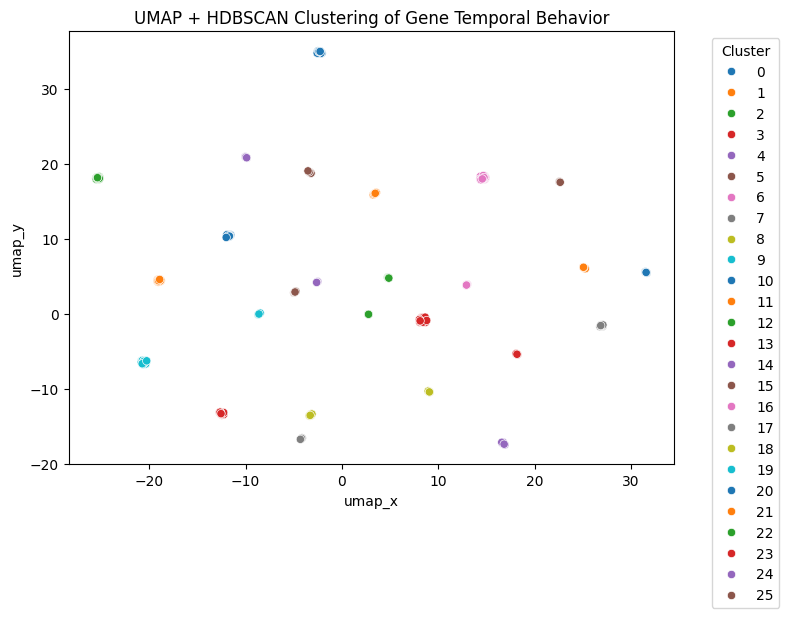

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_result, x="umap_x", y="umap_y", hue="hdbscan_cluster", palette="tab10")
plt.title("UMAP + HDBSCAN Clustering of Gene Temporal Behavior")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [4]:
# Drop rows with NaNs
df_filtered = df.dropna(subset=expr_cols + acc_cols).copy()

# Option 1: Use expression time series only
series_list = df_filtered[expr_cols].values.tolist()

# Optional: Use both features together
# series_list = (df_filtered[expr_cols].values + df_filtered[acc_cols].values).tolist()

gene_names = df_filtered['gene_name'].tolist()


In [7]:
from dtaidistance import dtw
dtw.use_c = False  # This works across versions


# Now compute DTW distance matrix (this will be slower but works)
distance_matrix = dtw.distance_matrix(series_list, compact=False)



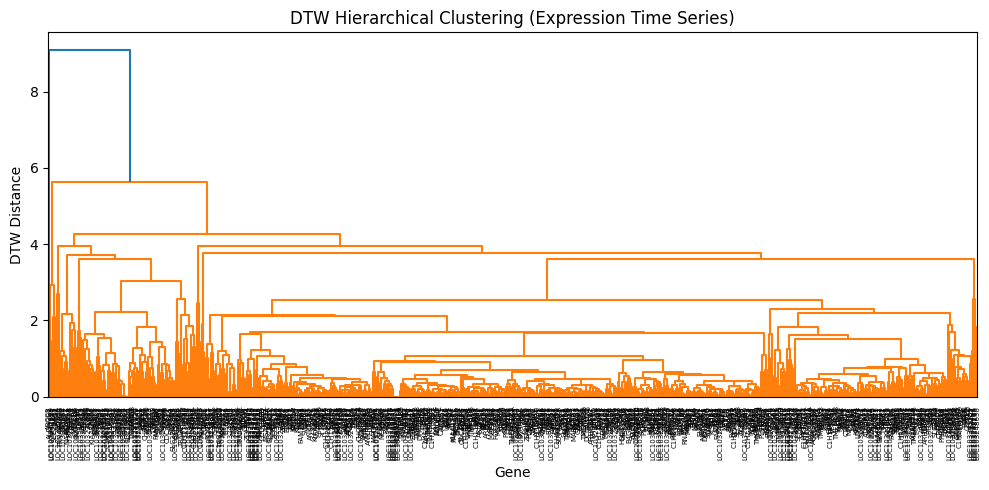

In [8]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# Convert to condensed distance matrix
from scipy.spatial.distance import squareform
condensed_dists = squareform(distance_matrix)

# Hierarchical clustering (you can try 'average', 'ward', etc.)
Z = linkage(condensed_dists, method='average')

# Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(Z, labels=gene_names, leaf_rotation=90)
plt.title("DTW Hierarchical Clustering (Expression Time Series)")
plt.xlabel("Gene")
plt.ylabel("DTW Distance")
plt.tight_layout()
plt.show()

# Get flat clusters (adjust threshold as needed)
labels = fcluster(Z, t=3, criterion='maxclust')  # 3 clusters
df_filtered['dtw_cluster'] = labels


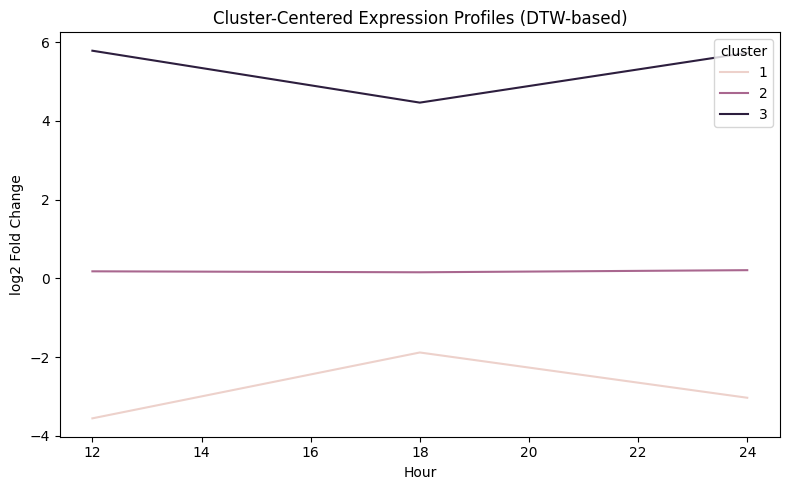

In [9]:
import seaborn as sns

df_filtered['cluster'] = labels
melted = df_filtered.melt(id_vars=["gene_name", "cluster"], 
                          value_vars=expr_cols, 
                          var_name="Timepoint", value_name="log2FC")

# Reorder timepoints numerically
time_order = {'log2FC_12h': 12, 'log2FC_18h': 18, 'log2FC_24h': 24}
melted["Time"] = melted["Timepoint"].map(time_order)

plt.figure(figsize=(8, 5))
sns.lineplot(data=melted, x="Time", y="log2FC", hue="cluster", estimator='mean', errorbar=None)
plt.title("Cluster-Centered Expression Profiles (DTW-based)")
plt.xlabel("Hour")
plt.ylabel("log2 Fold Change")
plt.tight_layout()
plt.show()
